In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/Users/weidanwu/Documents/MachineLearning/Code/FeedForward/FeedForwardNetwork/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

('Train data shape: ', (49000, 32, 32, 3))
('Train labels shape: ', (49000,))
('Validation data shape: ', (1000, 32, 32, 3))
('Validation labels shape: ', (1000,))
('Test data shape: ', (10000, 32, 32, 3))
('Test labels shape: ', (10000,))


In [15]:
tf.reset_default_graph()

height = 32
width = 32
channels = 3
n_inputs = height * width

n_layers = 3

conv_fmaps = [64, 128, 256, 16]
conv_ksizes = [3, 3, 3, 3]
conv_strides = [1, 1, 1, 1]
conv_paddings = ["SAME", "SAME", "SAME", "SAME"]
pooling_size = [2, 2]
pooling_stride = 2

n_fc1 = 256
n_outputs = 10

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
    y = tf.placeholder(tf.int64, shape=[None], name="y")
    is_training = tf.placeholder(tf.bool)

convs = []
pools = []
batches = []

for i in np.arange(n_layers):
    conv_input = (X if i == 0 else batches[i-1])
    convs.append(
        tf.layers.conv2d(conv_input, filters = conv_fmaps[i], kernel_size = conv_ksizes[i],
                         strides = conv_strides[i], padding = conv_paddings[i], activation = tf.nn.relu,
                         kernel_regularizer = tf.contrib.layers.l1_l2_regularizer(scale_l1 = 2.0, scale_l2 = 2.0)))
    pools.append(tf.layers.max_pooling2d(inputs = convs[i], pool_size = pooling_size, strides = pooling_stride))
    batches.append(tf.layers.batch_normalization(pools[i], training = is_training))

conv_output = tf.layers.dropout(batches[-1], rate = 0.5, training = is_training)
flat = tf.reshape(conv_output,
                  shape=[-1, conv_fmaps[n_layers - 1] * (height / (pooling_stride**n_layers))
                         * (width / (pooling_stride**n_layers))])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    y_out = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(y_out, name="Y_proba")
    
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_out, labels=y)
mean_loss = tf.reduce_mean(xentropy)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    # define our optimizer
    optimizer = tf.train.AdamOptimizer(1e-3) # select optimizer and set learning rate
    train_step = optimizer.minimize(mean_loss)


Training
Iteration 0: with minibatch training loss = 3.61 and accuracy of 0.098
Iteration 10: with minibatch training loss = 1.89 and accuracy of 0.422
Iteration 20: with minibatch training loss = 1.53 and accuracy of 0.483
Iteration 30: with minibatch training loss = 1.4 and accuracy of 0.512
Iteration 40: with minibatch training loss = 1.32 and accuracy of 0.545
Epoch 1, Overall loss = 1.66 and accuracy of 0.477


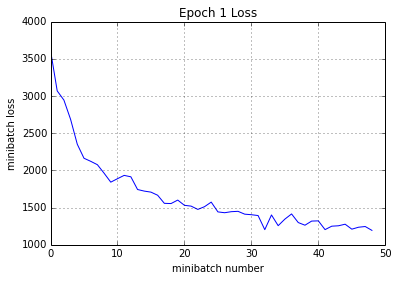

Validation
Epoch 1, Overall loss = 2.05 and accuracy of 0.406


Training
Iteration 0: with minibatch training loss = 1.12 and accuracy of 0.599
Iteration 10: with minibatch training loss = 1.05 and accuracy of 0.656
Iteration 20: with minibatch training loss = 1.05 and accuracy of 0.635
Iteration 30: with minibatch training loss = 1.01 and accuracy of 0.645
Iteration 40: with minibatch training loss = 1.04 and accuracy of 0.64
Epoch 1, Overall loss = 1.03 and accuracy of 0.643


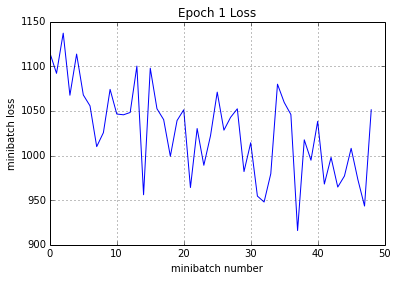

Validation
Epoch 1, Overall loss = 1.37 and accuracy of 0.537


Training
Iteration 0: with minibatch training loss = 0.841 and accuracy of 0.713
Iteration 10: with minibatch training loss = 0.849 and accuracy of 0.721
Iteration 20: with minibatch training loss = 0.777 and accuracy of 0.735
Iteration 30: with minibatch training loss = 0.871 and accuracy of 0.685
Iteration 40: with minibatch training loss = 0.853 and accuracy of 0.699
Epoch 1, Overall loss = 0.84 and accuracy of 0.708


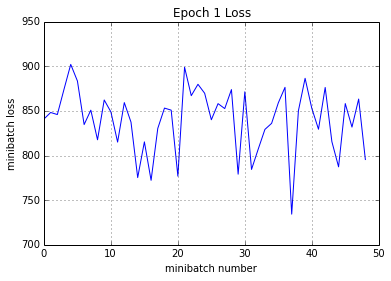

Validation
Epoch 1, Overall loss = 0.922 and accuracy of 0.681


Training
Iteration 0: with minibatch training loss = 0.785 and accuracy of 0.716
Iteration 10: with minibatch training loss = 0.679 and accuracy of 0.751
Iteration 20: with minibatch training loss = 0.643 and accuracy of 0.76
Iteration 30: with minibatch training loss = 0.71 and accuracy of 0.75
Iteration 40: with minibatch training loss = 0.721 and accuracy of 0.752
Epoch 1, Overall loss = 0.706 and accuracy of 0.752


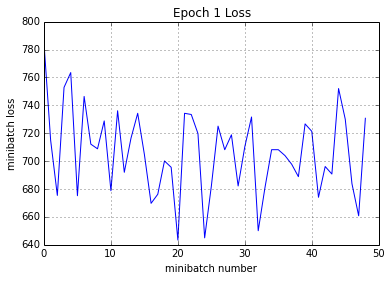

Validation
Epoch 1, Overall loss = 0.807 and accuracy of 0.715


Training
Iteration 0: with minibatch training loss = 0.62 and accuracy of 0.774
Iteration 10: with minibatch training loss = 0.585 and accuracy of 0.784
Iteration 20: with minibatch training loss = 0.541 and accuracy of 0.813
Iteration 30: with minibatch training loss = 0.624 and accuracy of 0.775
Iteration 40: with minibatch training loss = 0.588 and accuracy of 0.805
Epoch 1, Overall loss = 0.612 and accuracy of 0.784


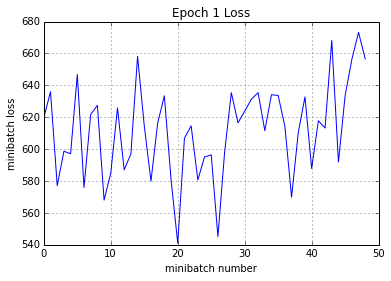

Validation
Epoch 1, Overall loss = 0.73 and accuracy of 0.745


Training
Iteration 0: with minibatch training loss = 0.506 and accuracy of 0.825
Iteration 10: with minibatch training loss = 0.512 and accuracy of 0.835
Iteration 20: with minibatch training loss = 0.547 and accuracy of 0.797
Iteration 30: with minibatch training loss = 0.586 and accuracy of 0.809
Iteration 40: with minibatch training loss = 0.591 and accuracy of 0.798
Epoch 1, Overall loss = 0.541 and accuracy of 0.809


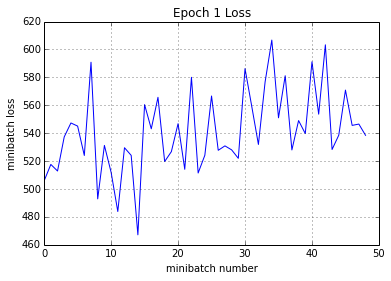

Validation
Epoch 1, Overall loss = 0.704 and accuracy of 0.76


Training
Iteration 0: with minibatch training loss = 0.459 and accuracy of 0.836
Iteration 10: with minibatch training loss = 0.451 and accuracy of 0.839
Iteration 20: with minibatch training loss = 0.461 and accuracy of 0.834
Iteration 30: with minibatch training loss = 0.427 and accuracy of 0.846
Iteration 40: with minibatch training loss = 0.492 and accuracy of 0.815
Epoch 1, Overall loss = 0.464 and accuracy of 0.836


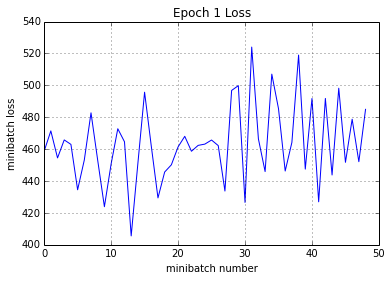

Validation
Epoch 1, Overall loss = 0.645 and accuracy of 0.777


Training
Iteration 0: with minibatch training loss = 0.401 and accuracy of 0.86
Iteration 10: with minibatch training loss = 0.386 and accuracy of 0.874
Iteration 20: with minibatch training loss = 0.411 and accuracy of 0.85
Iteration 30: with minibatch training loss = 0.43 and accuracy of 0.851
Iteration 40: with minibatch training loss = 0.47 and accuracy of 0.826
Epoch 1, Overall loss = 0.416 and accuracy of 0.853


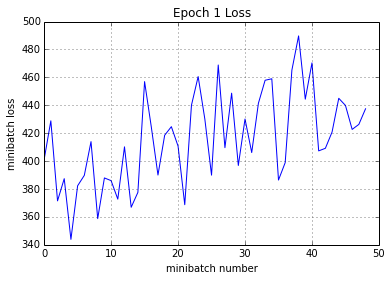

Validation
Epoch 1, Overall loss = 0.681 and accuracy of 0.766


Training
Iteration 0: with minibatch training loss = 0.337 and accuracy of 0.882
Iteration 10: with minibatch training loss = 0.34 and accuracy of 0.882
Iteration 20: with minibatch training loss = 0.326 and accuracy of 0.892
Iteration 30: with minibatch training loss = 0.385 and accuracy of 0.856
Iteration 40: with minibatch training loss = 0.363 and accuracy of 0.876
Epoch 1, Overall loss = 0.365 and accuracy of 0.871


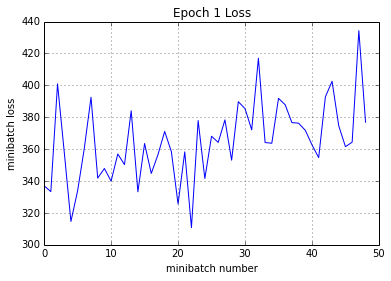

Validation
Epoch 1, Overall loss = 0.65 and accuracy of 0.786


Training
Iteration 0: with minibatch training loss = 0.305 and accuracy of 0.901
Iteration 10: with minibatch training loss = 0.282 and accuracy of 0.895
Iteration 20: with minibatch training loss = 0.297 and accuracy of 0.896
Iteration 30: with minibatch training loss = 0.313 and accuracy of 0.899
Iteration 40: with minibatch training loss = 0.33 and accuracy of 0.884
Epoch 1, Overall loss = 0.322 and accuracy of 0.887


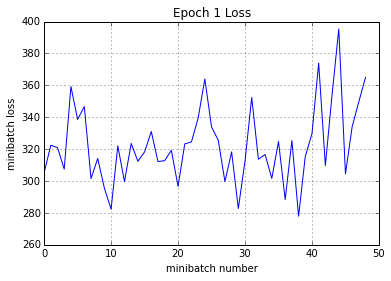

Validation
Epoch 1, Overall loss = 0.681 and accuracy of 0.78




In [16]:
def run_model(session, predict, update_ops, loss_val, Xd, yd,
              epochs=10, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy, update_ops]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.3g}"\
                      .format(iter_cnt,loss,np.sum(corr)*1.0/actual_batch_size))
            iter_cnt += 1
        total_correct = correct*1.0/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        for i in np.arange(10):
            print('Training')
            run_model(sess,y_out,update_ops,mean_loss,X_train,y_train,1,1000,10,train_step,True)
            print('Validation')
            run_model(sess,y_out,update_ops,mean_loss,X_val,y_val,1,1000)
            print('\n')